<a href="https://colab.research.google.com/github/mananthavelu/data_and_statistical_modeling/blob/main/12_feed_forward_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Tensor Basics

In [4]:
# 0D - 1,2, 0.5
# 1D  - [1,2,3,4,5]
# 2D - [[1,2,3],[4,5,6]]
# Data type - int, float, double, long, short, byte
import torch
import numpy as np

a = torch.tensor([1,2,3,4,5])
print(a)
print(a[1])
print(type(a))

tensor([1, 2, 3, 4, 5])
tensor(2)
<class 'torch.Tensor'>


In [2]:
b = a.type(torch.float)
print(a.ndimension())
print(a.size())

1
torch.Size([5])


#### Tensor  - with numpy array and pandas series

In [ ]:
# Create Tensor from numpy array
numpy_array = np.array([1,2,3])
tensor_vector = torch.from_numpy(numpy_array)
print(type(numpy_array))
print(type(tensor_vector))

#Back to numpy array
np_array = tensor_vector.numpy()
print(type(np_array))

# From pandas series
import pandas as pd
pd_series = pd.Series([2,4,5, 0.2])
tensor_fr_series = torch.from_numpy(pd_series.values)
print(tensor_fr_series.dtype)
print(tensor_fr_series.type())

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
torch.float64
torch.DoubleTensor


In [ ]:
a = torch.Tensor([1,2,3,4,5])
a_col = a.view(5,1)
print(a_col)
print(a_col.size())
print(a_col.ndimension())

tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.]])
torch.Size([5, 1])
2


#### Tensor operations

In [ ]:
# Vector additions
u = torch.Tensor([1,3])
v = torch.Tensor([2,4])
print(u+v)

# Adding constant to a Tensor/Broadcasting
u = torch.tensor([1,2,4])
v = u + 1
print(v)

# Vector multiplication with a scalar
x = torch.Tensor([1,2])
y = torch.Tensor([3,15])
z = u + v
print(x*y)
print(x*2)
print(x.T)
print(x.size())
print(x.T)
print(x.T.size())
print(x.T*y)
print(x.T.dot(y))
print(torch.dot(x,y))



tensor([3., 7.])
tensor([2, 3, 5])
tensor([ 3., 30.])
tensor([2., 4.])
tensor([1., 2.])
torch.Size([2])
tensor([1., 2.])
torch.Size([2])
tensor([ 3., 30.])
tensor(33.)
tensor(33.)


C:\Users\32470\AppData\Local\Temp\ipykernel_12516\2943338211.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  print(x.T)


#### Applying Torch functions

In [ ]:
# torch functions
sin_u = torch.sin(u)
print(sin_u)
print(x.mean())
print(x.max())


# We can also apply functions to Tensors
print(torch.linspace(-2,2,steps = 5))# returns evenly spaced numbers

tensor([ 0.8415,  0.9093, -0.7568])
tensor(1.5000)
tensor(2.)
tensor([-2., -1.,  0.,  1.,  2.])


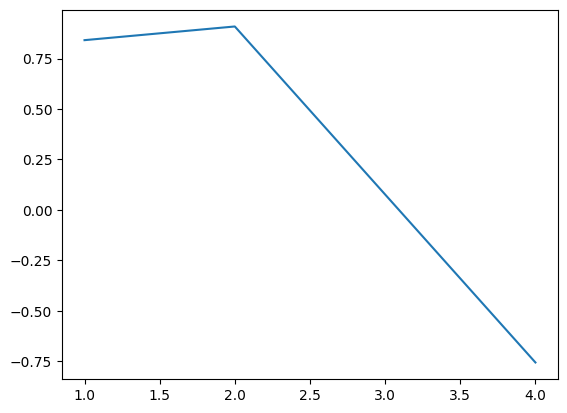

In [ ]:
# Plot values
import matplotlib.pyplot as plt

plt.plot(u.numpy(), sin_u.numpy())
plt.show()

In [ ]:
# Two dimensional tensors

a = [[11,12,13],[21,22,23],[31,32,33]]
b = [[1,2],[2,4,]]
c = [[0,3],[6,1,]]
A = torch.tensor(a)

print(A)
print(A.ndimension())#Gives the number of dimensions
print(A.shape)
print(A.size())
print(A.numel())


#Indexing and slicing
print("Indexing and slicing")
print(A[2][0])#2nd row, 0th column
print(A[2,0])#2nd row, 0th column
print(A[0,0:2])#Slice 0th row for columns 0 to 2 (excluding)
print(A[1:2,2])#Slice rows 1 to 3 (excluding) for columns 2

tensor([[11, 12, 13],
        [21, 22, 23],
        [31, 32, 33]])
2
torch.Size([3, 3])
torch.Size([3, 3])
9
Indexing and slicing
tensor(31)
tensor(31)
tensor([11, 12])
tensor([23])


In [ ]:
# Tensor operations
B  = torch.tensor(b)
C  = torch.tensor(c)

# Addition
print(B)
print(C)
print(B+C)

#Multiplication
print("Multiplication")
print(2*B)

tensor([[1, 2],
        [2, 4]])
tensor([[0, 3],
        [6, 1]])
tensor([[1, 5],
        [8, 5]])
Multiplication
tensor([[2, 4],
        [4, 8]])


#### Differentiation in PyTorch

In [ ]:
# Create a tensor

x = torch.tensor(2.0, requires_grad=True)
print(x)
x.shape
x.size()
x.ndimension()
x.ndim

tensor(2., requires_grad=True)


0

In [ ]:
# Equation
y = x**2
print(y)
print(y.ndim)
print(x.grad)

tensor(4., grad_fn=<PowBackward0>)
0
None


In [ ]:
y.backward()

In [ ]:
x.grad

tensor(4.)

In [ ]:
print(x)
print(y)

tensor(2., requires_grad=True)
tensor(4., grad_fn=<PowBackward0>)


In [ ]:
print('data:',x.data)
print('grad_fn:',x.grad_fn)
print('grad:',x.grad)
print("is_leaf:",x.is_leaf)
print("requires_grad:",x.requires_grad)

data: tensor(2.)
grad_fn: None
grad: tensor(4.)
is_leaf: True
requires_grad: True


In [ ]:
print('data:',y.data)
print('grad_fn:',y.grad_fn)
print('grad:',y.grad)
print("is_leaf:",y.is_leaf)
print("requires_grad:",y.requires_grad)

data: tensor(4.)
grad_fn: <PowBackward0 object at 0x000001FE07FDEC50>
grad: None
is_leaf: False
requires_grad: True


C:\Users\32470\AppData\Local\Temp\ipykernel_12516\1355624623.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  print('grad:',y.grad)


In [ ]:
# Calculate the y = x^2 + 2x + 1, then find the derivative

x = torch.tensor(2.0, requires_grad = True)
y = x ** 2 + 2 * x + 1
print("The result of y = x^2 + 2x + 1: ", y)
y.backward()
print("The dervative at x = 2: ", x.grad)

The result of y = x^2 + 2x + 1:  tensor(9., grad_fn=<AddBackward0>)
The dervative at x = 2:  tensor(6.)


In [ ]:
# Practice: Calculate the derivative of y = 2x^3 + x at x = 1
x = torch.tensor(1.0, requires_grad = True)
y = 2*x**3 + x
y.backward()

# Type your code here

In [ ]:
x.grad

tensor(7.)

In [6]:
# Buiding a NN model
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [7]:
# Doanloading the training ata from open datasets

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 307kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.48MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]


In [8]:
# Doanload the test data from open datasets

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

In [15]:
batch_size = 64

# Create data loaders

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
# Creating models

